# Decompose HSC observed QSO image

This notebook requires standard python libraries and the publicly available packages on github:
See https://github.com/dartoon/galight/blob/master/requirements.txt

This notebook has been tested with galight == 0.1.4

For more information, please contact me: dingxuheng@126.com

This notebook is very similar to the 'galight_HST_QSO.ipynb', only that the noise_map, PSF are input to the fittings. 

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

#Data is available at: https://drive.google.com/file/d/1ZO9-HzV8K60ijYWK98jGoSoZHjIGW5Lc/view?usp=sharing
fitsFile = pyfits.open('../example_files/HSC/QSO/000017.88+002612.6_HSC-I.fits')

#Load the fov image data:
fov_image = fitsFile[1].data # check the back grounp

#Derive the header informaion, might be used to obtain the pixel scale and the exposure time.
header = fitsFile[1].header # if target position is add in WCS, the header should have the wcs information, i.e. header['EXPTIME']

#Derive the fov noise level map:
err_data= fitsFile[3].data ** 0.5

#Calculate the zeropoint for HSC filters:
file_header0 = fitsFile[0].header
FLUXMAG0 = file_header0['FLUXMAG0']
zp =  2.5 * np.log10(FLUXMAG0)   # This is something Xuheng can't make sure.

##Load the PSF data:
#PSF = pyfits.getdata('../example_files/HSC/QSO/000017.88+002612.6_HSC-I_psf.fits')

Estimating the background light ... ... ...
Plot target cut out zoom in:


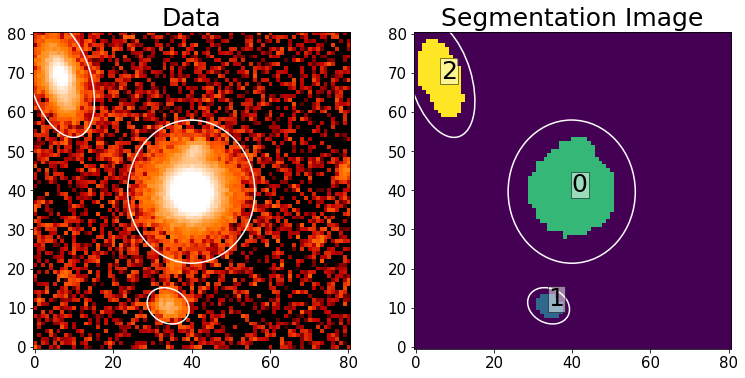

label     xcentroid          ycentroid      ...     kron_flux      kron_fluxerr
                                            ...                                
----- ------------------ ------------------ ... ------------------ ------------
    1  33.97233640859878 10.483390376980072 ... 23.189933440707634          nan
    0 39.878512652743495  39.65420140516439 ...  935.9413749959695          nan
    3 6.4403712688177945  68.56712756371142 ... 162.45549646159748          nan


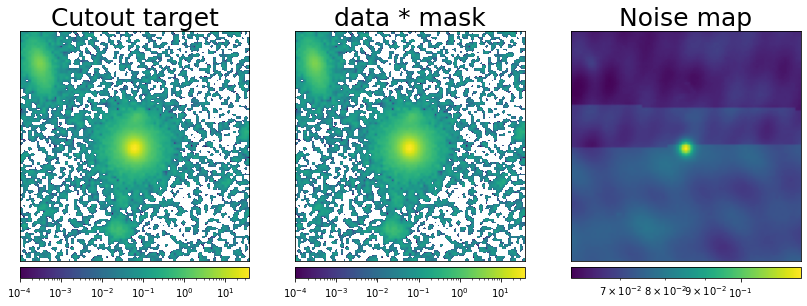

The PSF has not been assigned yet. For a direct asymmetry measurement, it is OK.
The data_process is ready to go to pass to FittingSpecify!


In [30]:
from galight.data_process import DataProcess

#RA, DEC information of the QSO:
QSO_RA, QSO_DEC = 0.07452999800443649, 0.4368380010128021
data_process = DataProcess(fov_image = fov_image, fov_noise_map = err_data, target_pos = [QSO_RA, QSO_DEC],
                           pos_type = 'wcs', header = header,
                          rm_bkglight = True, if_plot=False, zp = zp)

#Generate the fitting materials
data_process.generate_target_materials(radius=None, create_mask = False, nsigma=2.8,
                                      exp_sz= 1.5, npixels = 15, if_plot=True)

#Check if all the materials is given, if so to pass to the next step.
data_process.checkout() #Check if all the materials is known.

## One can manually modify the aperture and segm for a specific asy measure task using following box:
You can skip this box if you don't need the function. 

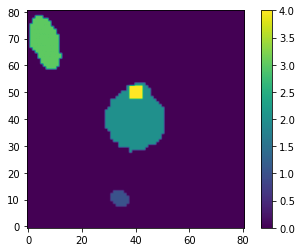

In [31]:
#Update the apretures:
import copy
apertures = copy.deepcopy(data_process.apertures)
add_aperture0 = copy.deepcopy(apertures[0])
add_aperture0.a, add_aperture0.b = 3, 3 # A a b for aperture
add_aperture0.positions = np.array([40,50])
data_process.apertures = apertures +  [add_aperture0]#Pass apertures to the data_process

#Update the segm map:
from galight.tools.measure_tools import mask_obj
mask = mask_obj(data_process.target_stamp, [add_aperture0])
data_process.segm_deblend = data_process.segm_deblend*mask[0] + (1-mask[0])*(np.max(data_process.segm_deblend)+1)
plt.imshow(data_process.segm_deblend, origin='lower')
plt.colorbar()
plt.show()

The settings for the fitting is done. Ready to pass to FittingProcess. 
  However, please make updates manullay if needed.


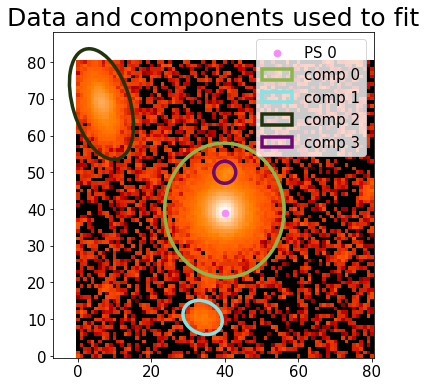

In [35]:
#Start to produce the class and params for lens fitting.
#For more details, see notebook galight_HST_QSO.ipynb
from galight.fitting_specify import FittingSpecify
fit_sepc = FittingSpecify(data_process)
fit_sepc.prepare_fitting_seq(point_source_num = 1)
#Using following line: want to fix Sersic_n as 4 for the source_id = 0, and if want to fix the QSO and host center:
# fit_sepc.prepare_fitting_seq(point_source_num = 1, fix_n_list= [[0,4]], fix_center_list = [[0,0]])

#Plot the initial settings for fittings. 
fit_sepc.plot_fitting_sets()

fit_sepc.build_fitting_seq()

from galight.fitting_process import FittingProcess
fit_run = FittingProcess(fit_sepc)

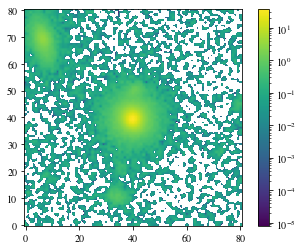

Measuring the position for minimized asy...
Optimization terminated successfully.
         Current function value: 76.137233
         Iterations: 97
         Function evaluations: 182
The pixel position that gives you the minimized asy: [-0.12941909 -0.65453475]
Plot the minimized abs residual:


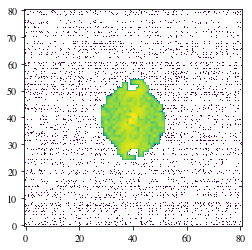

Plot the region to estiamte the background asymmetry:


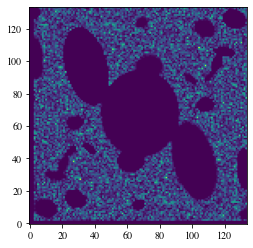

asymmetry : 0.04445924857095499


In [36]:
from galight.tools.asymmetry_tools import Measure_asy
from galight.tools.astro_tools import plt_fits
import pickle

if_remeasure_bkg = True
asy_class = Measure_asy(fit_run, seg_cal_reg = 'or', obj_id=0)  #The obj_id is the comp_id you see in figure above.

#Plot the image data:
plt_fits(asy_class.img,colorbar=True)

asy_class.asy_segm(mask_type='segm')  #Try also mask_type='aper'; you can feed you own segm if you have one.

pos = asy_class.find_pos()
print('The pixel position that gives you the minimized asy:', pos["x"])
asy = asy_class.cal_asymmetry(rotate_pix = pos["x"], if_remeasure_bkg=if_remeasure_bkg, 
                              if_plot=True, if_plot_bkg=True)
print('asymmetry :', asy)